# Proyek Macihne Learning: Chest Image
- **Nama:** Kurnia Raihan Ardian
- **Email:** raihanardila22@gmail.com
- **ID Dicoding:** raihanardila

Persiapan Library

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import random
from PIL import Image
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


Load Dataset

In [80]:
# Download Dataset dari KaggleHub
dataset_path = "/Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# ✅ Cek apakah folder training & validation ada
print("🔍 Train folder:", os.path.exists(train_dir))
print("🔍 Validation folder:", os.path.exists(val_dir))
print(" Test folder:", os.path.exists(test_dir))


# ✅ Cek jumlah gambar di setiap folder
for root, dirs, files in os.walk(dataset_path):
    print(f"📁 {root}: {len(files)} file")


for category in os.listdir(train_dir):
    cat_train_path = os.path.join(train_dir, category)
    cat_test_path = os.path.join(test_dir, category)
    os.makedirs(cat_test_path, exist_ok=True)

    # Ambil 10% data dari train untuk test
    files = os.listdir(cat_train_path)
    test_size = int(0.1 * len(files))
    test_files = random.sample(files, test_size)

    for file in test_files:
        shutil.move(os.path.join(cat_train_path, file), os.path.join(cat_test_path, file))

print("✅ Data telah dipisahkan menjadi Train, Validation, dan Test Set.")


🔍 Train folder: True
🔍 Validation folder: True
 Test folder: True
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray: 0 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test: 0 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA: 2762 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/NORMAL: 1053 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray: 0 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/test: 0 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/test/PNEUMONIA: 390 file
📁 /Users/s2idev/.cache/kagglehub/datasets/paultimothymooney/ches

Data Augmentation & Preprocessing

In [81]:
# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Meningkatkan rotasi
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],  # Variasi pencahayaan
    horizontal_flip=True
)


val_datagen = ImageDataGenerator(rescale=1./255)  # Tidak perlu augmentasi pada validasi

train_generator = train_datagen.flow_from_directory(
    train_dir,  # ✅ Path dataset training yang benar
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # ✅ Path dataset validation yang benar
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

x_batch, y_batch = next(train_generator)
print("✅ Dataset berhasil dimuat:", x_batch.shape, y_batch.shape)

num_classes = len(train_generator.class_indices)
print("📂 Kelas dalam dataset:", train_generator.class_indices)




Found 1823 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 4017 images belonging to 2 classes.
✅ Dataset berhasil dimuat: (32, 150, 150, 3) (32, 2)
📂 Kelas dalam dataset: {'NORMAL': 0, 'PNEUMONIA': 1}


Membangun Model CNN

In [82]:
# Membangun Model CNN
# Membangun Model CNN yang lebih kompleks
model = Sequential([
    Input(shape=(150,150,3)),  # Gunakan Input Layer
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
])

/Users/s2idev/PycharmProjects/xraymodel/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile Model

In [83]:
# Compile Model
loss_function = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.0003), loss=loss_function, metrics=['accuracy'])


learning rate

In [84]:
def lr_schedule(epoch):
    initial_lr = 0.0005
    drop = 0.5
    epochs_drop = 5
    return initial_lr * (drop ** (epoch // epochs_drop))

lr_scheduler = LearningRateScheduler(lr_schedule)


Callback: EarlyStopping & ReduceLROnPlateau

In [85]:
# Callback: EarlyStopping & ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)



Training Model

In [86]:
# Training Model
history = model.fit(
    train_generator, validation_data=val_generator, epochs=30, callbacks=[early_stopping, reduce_lr, lr_scheduler]
)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7195 - loss: 1.3674 - val_accuracy: 0.5000 - val_loss: 5.6449 - learning_rate: 5.0000e-04
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7758 - loss: 0.4602 - val_accuracy: 0.5000 - val_loss: 11.1706 - learning_rate: 5.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8330 - loss: 0.3629 - val_accuracy: 0.5000 - val_loss: 10.2907 - learning_rate: 5.0000e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8427 - loss: 0.3659 - val_accuracy: 0.5000 - val_loss: 6.4931 - learning_rate: 5.0000e-05
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8203 - loss: 0.4109 - val_accuracy: 0.5000 - val_loss: 14.4159 - learning_rate: 5.0000e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8377 - loss: 0.3670 - val_accuracy: 0.5000 - val_loss: 9.0890 - learning_rate: 2.5000e-04
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.838

Evaluasi Model

In [87]:
# Evaluasi Model
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Akurasi Training: {train_acc*100:.2f}%")
print(f"✅ Akurasi Validation: {val_acc*100:.2f}%")
print(f"✅ Akurasi Model pada Test Set: {test_acc * 100:.2f}%")

126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 533ms/step - accuracy: 0.8464 - loss: 0.3158
✅ Akurasi Training: 89.30%
✅ Akurasi Validation: 56.25%
✅ Akurasi Model pada Test Set: 85.14%


Plot Akurasi dan Loss

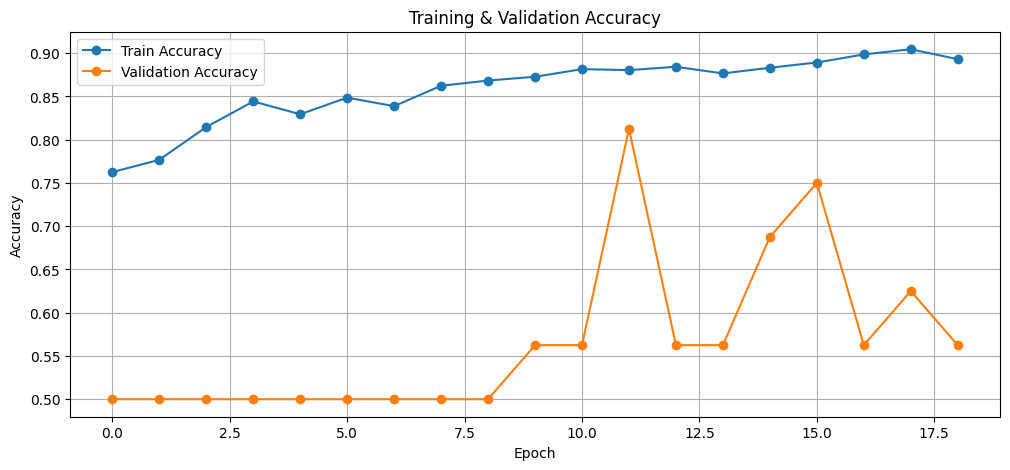

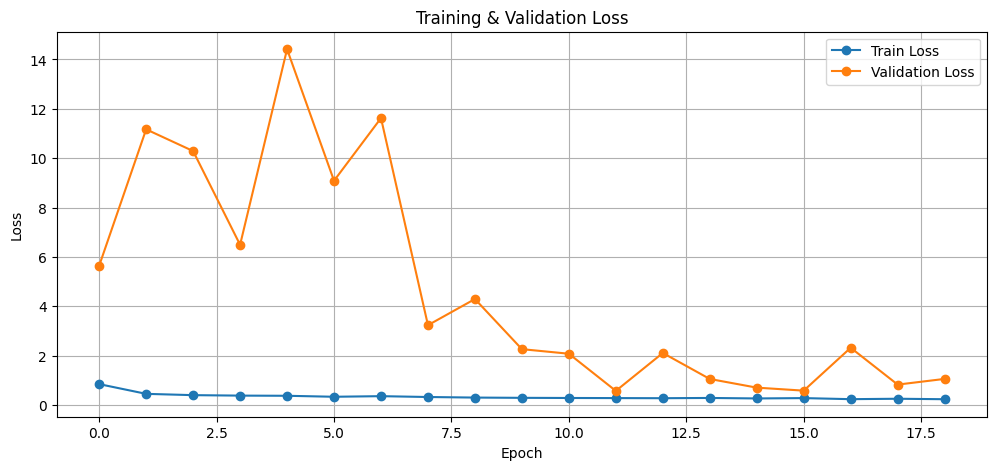

In [88]:
# Plot Akurasi dan Loss

# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Menyimpan Model dalam 3 Format

In [89]:
# Menyimpan Model dalam 3 Format
model.save("saved_model.keras")

model.save("saved_model.h5")

model.export("saved_model/")  # Format TensorFlow SavedModel


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_1300')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  6539442304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539441248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539449968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539450496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539449440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539449616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539469216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539469040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539471504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539472032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6539470976: TensorSpec(shape=(), dtype=tf.resource, name=None)


Konversi ke TF-Lite

In [90]:
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/")
tflite_model = converter.convert()
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

    # Pastikan folder `assets/` ada
assets_dir = "saved_model/assets"
os.makedirs(assets_dir, exist_ok=True)

# Simpan label ke dalam `assets/`
labels = ["Normal", "Pneumonia", "Tuberculosis"]
with open(os.path.join(assets_dir, "labels.txt"), "w") as f:
    f.write("\n".join(labels))

print("✅ Label berhasil ditambahkan ke saved_model/assets/")

W0000 00:00:1740743188.207266  138494 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1740743188.209577  138494 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-02-28 18:46:28.216639: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/
2025-02-28 18:46:28.219467: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-02-28 18:46:28.219485: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model/
2025-02-28 18:46:28.265292: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-02-28 18:46:28.460373: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model/
2025-02-28 18:46:28.491535: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 275380 microseconds.


✅ Label berhasil ditambahkan ke saved_model/assets/


Simpan label TF-Lite

In [91]:
# Simpan label TF-Lite
labels = ["Normal", "Pneumonia", "Tuberculosis"]
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))


Konversi Model ke TFJS

In [92]:
# Konversi Model ke TFJS
!pip install tensorflowjs  # Pastikan TensorFlow.js sudah terinstal
os.makedirs("tfjs_model", exist_ok=True)
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model